# 기초 설정


- `requirements.txt`에 명시된 버젼의 패키지 사용

In [ ]:
# 공통 모듈 임포트
import os
import re  
import time
from tqdm.notebook import tqdm  # 반복문 진행상태 출력
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")  # 불필요한 경고 무시


# 넘파이
import numpy as np
assert np.__version__ == "1.19.5"


# 판다스
import pandas as pd
assert pd.__version__ == "1.1.5"


# 텐서플로우
import tensorflow as tf
assert tf.__version__ == "2.4.1"


# 케라스
import keras


# 사이킷런
import sklearn
assert sklearn.__version__ == "0.23.2"


# seaborn
import seaborn as sns
assert sns.__version__ == "0.11.1"


# matplotlib
import matplotlib
assert matplotlib.__version__ == "3.3.4"


# 깔끔한 그래프 출력을 위해 
%matplotlib inline
sns.set_style("whitegrid")


# 한글폰트 설정 (맥 기준 - 운영체제에 맞게 변경)
import matplotlib.pyplot as plt
matplotlib.rcParams['axes.unicode_minus'] = False 
matplotlib.rcParams['font.family'] = "AppleGothic"  


print("기초 설정이 완료되었습니다.")

기초 설정이 완료되었습니다.


## 데이터 불러오기

<br>

1. 고객 정보 데이터
2. 차량 정보 데이터
3. 고객 접촉 이력 데이터

In [ ]:
# 저장된 데이터 로드
customers = pd.read_csv("./_21년 해카톤_고객정보.csv", encoding = "euc-kr")  # 고객정보
cars = pd.read_csv("./_21년 해카톤_차량정보.csv", encoding = "euc-kr")       # 차량정보
contacts = pd.read_csv("./_21년 해카톤_접촉정보.csv", encoding = "euc-kr")   # 접촉이력정보

print(customers.shape)
print(cars.shape)
print(contacts.shape)

(1096206, 9)
(1835830, 10)
(17734097, 5)


# 데이터 전처리


본격적인 Task 수행에 앞서, 주어진 데이터의 특징을 파악함과 동시에 분석에 용이한 형태로 일차 가공.

## 고객정보 데이터

In [ ]:
# 전체 데이터 대비 결측치 비율
for cols in customers.columns:
    print("Missing entries in <{}>: {} %".format(cols, np.round(customers[cols].isnull().sum() / len(customers), 3)))

Missing entries in <CUS_ID>: 0.0 %
Missing entries in <PSN_BIZR_YN>: 0.873 %
Missing entries in <SEX_SCN_NM>: 0.0 %
Missing entries in <TYMD>: 0.0 %
Missing entries in <CUS_ADM_TRY_NM>: 0.132 %
Missing entries in <CUS_N_ADMZ_NM>: 0.134 %
Missing entries in <CUS_ADMB_NM>: 0.78 %
Missing entries in <CLB_HOUS_PYG_NM>: 0.432 %
Missing entries in <REAI_BZTC_AVG_PCE>: 0.464 %


- 다음의 특성들에 결측치가 존재함.

    - 개인사업자 여부
    - 주소_행정시도명
    - 주소_시군구명
    - 주소_행정동명
    - 주택 평형
    - 주택 평균가격

### 개인사업자여부

In [ ]:
# 개인 사업자 수
customers.PSN_BIZR_YN.value_counts()

Y    138942
Name: PSN_BIZR_YN, dtype: int64

- 약 14만명 정도의 고객이 개인 사업자 등록이 되어있음.

- 일반적으로, 개인사업자에 해당하는 고객의 경우 절세 등의 강력한 혜택을 누리기 위해 등록을 했을 것.
    - 해당 칼럼의 결측치들을 개인사업자가 아닌 고객들이라고 판단.

In [ ]:
# 결측치를 일괄적으로 "N"으로 인코딩
customers["PSN_BIZR_YN"] = customers["PSN_BIZR_YN"].fillna("N")

### 성별

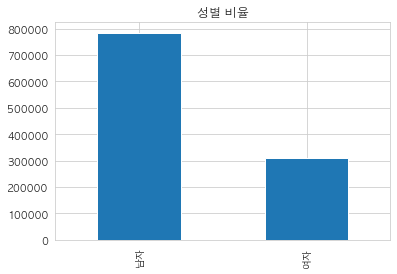

In [ ]:
# 고객 성별 비교
customers.SEX_SCN_NM.value_counts().plot(kind="bar", title="성별 비율")
plt.show()

- 남성 고객이 여성 고객보다 약 2.5배 더 많음.
- 별도의 전처리 X

### 고객 생년월

- 생년월 정보에서 "연도"만 별도로 추출.
- 출생년도가 2021년 이상인 엔트리들을 오류로 분류 및 삭제.

In [ ]:
# 고객 생년월일 전처리
customers["B_YEAR"] = customers["TYMD"].astype(str).apply(lambda x: x[:4]).astype(int)     # 고객의 출생연도
customers.drop("TYMD", axis=1, inplace=True)   # 생년월일 칼럼 삭제

# 출생년도에 오류가 있는 엔트리 제거
error_index = (customers["B_YEAR"].astype(int) > 2021)
customers.drop(customers["B_YEAR"][error_index].index, axis=0, inplace=True)
customers.reset_index(drop=True, inplace=True)

### 고객 주소


- 주소_행정시도명: 별도의 전처리 x
- 주소_시군구명: 별도의 전처리 X
- 주소_행정동명: 결측치가 많기 때문에 유의미한 정보를 추출해내기 어려움.

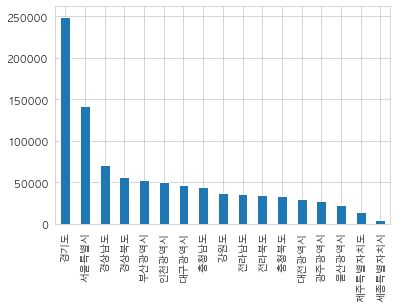

In [ ]:
# 행정시도별 고객수
customers.CUS_ADM_TRY_NM.value_counts().plot(kind="bar")
plt.show()

In [ ]:
# 시군구별 고객수 내림차순 정렬
customers.CUS_N_ADMZ_NM.value_counts()

서구     29019
북구     25881
남구     17539
중구     16228
동구     15550
       ...  
임실군      377
진안군      357
장수군      324
옹진군      190
울릉군       96
Name: CUS_N_ADMZ_NM, Length: 227, dtype: int64

### 주택 정보

- 주택 평수
    - "33A" 등의 형식으로 기록된 값들이 있기 때문에 수치형 자료로 전처리.
    - 평수가 0일 수는 없으므로 해당 엔트리들을 결측치로 수정.

- 주택 평균가격
    - 별도의 전처리 X


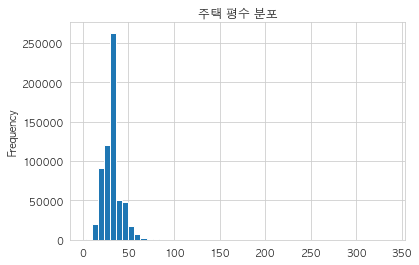

In [ ]:
# 주택 평수 전처리
dat = customers["CLB_HOUS_PYG_NM"].dropna().apply(lambda x: re.sub(r"\D+[\d\D]*", "", x))
customers["CLB_HOUS_PYG_NM"] = dat.astype(int)

# 주택 평수가 0인 엔트리를 결측치로 수정
error_idx = customers[customers["CLB_HOUS_PYG_NM"] == 0].index
customers.at[error_idx, "CLB_HOUS_PYG_NM"] = np.nan

# 주택 평수에 대한 히스토그램
customers["CLB_HOUS_PYG_NM"].plot(kind="hist", bins=50, title="주택 평수 분포")
plt.show()

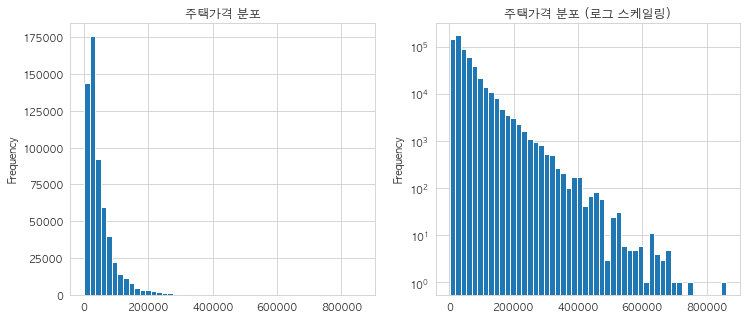

In [ ]:
plt.figure(figsize=(12,5))

# 주택 가격에 대한 히스토그램
plt.subplot(1,2,1)
customers["REAI_BZTC_AVG_PCE"].plot(kind="hist", bins=50, title="주택가격 분포")

# 로그 히스토그램
plt.subplot(1,2,2)
customers["REAI_BZTC_AVG_PCE"].plot(kind="hist", bins=50, title="주택가격 분포 (로그 스케일링)")
plt.yscale("log")

plt.show()

- 주택가격은 지역별로 상이하므로, 주택 가격을 평수로 나눠 "평당 주택 가격" 변수를 정의한다.

In [ ]:
# 평당 주택 가격 변수 추가
customers["PCE_PER_PYG"] = customers["REAI_BZTC_AVG_PCE"] / customers["CLB_HOUS_PYG_NM"]

- 평당 주택 가격은 고객의 경제력에 대한 지표가 될 수 있음.
- 약 45% 정도의 결측치는 추후 회귀 모델을 사용해 보완.

In [ ]:
# 전처리된 고객정보 데이터
print(customers.shape)
customers.head()

(1096183, 10)


,CUS_ID,PSN_BIZR_YN,SEX_SCN_NM,CUS_ADM_TRY_NM,CUS_N_ADMZ_NM,CUS_ADMB_NM,CLB_HOUS_PYG_NM,REAI_BZTC_AVG_PCE,B_YEAR,PCE_PER_PYG
0,AOZZZZO010000035,N,남자,전라남도,영암군,시종면,NaN,NaN,1930,NaN
1,AOZZZZO010000067,N,남자,경상남도,진주시,NaN,NaN,NaN,1933,NaN
2,AOZZZZO010000190,N,남자,NaN,NaN,NaN,23.0,13400.0,1937,582.608696
3,AOZZZZO010000371,N,남자,서울특별시,마포구,NaN,NaN,NaN,1940,NaN
4,AOZZZZO010000492,N,남자,광주광역시,북구,NaN,NaN,NaN,1941,NaN


## 차량정보

In [ ]:
# 전체 데이터 대비 결측치 비율
for cols in cars.columns:
    print("Missing entries in <{}>: {}".format(cols, np.round(cars[cols].isnull().sum() / len(cars), 3)))

Missing entries in <CAR_ID>: 0.0
Missing entries in <CUS_ID>: 0.0
Missing entries in <WHOT_DT>: 0.0
Missing entries in <CAR_HLDG_STRT_DT>: 0.0
Missing entries in <CAR_HLDG_FNH_DT>: 0.487
Missing entries in <CAR_NM>: 0.0
Missing entries in <CAR_CGRD_NM_1>: 0.0
Missing entries in <CAR_CGRD_NM_2>: 0.0
Missing entries in <CAR_ENG_NM>: 0.0
Missing entries in <CAR_TRIM_NM>: 0.0


- "차량 보유 종료일" 특성에만 결측치 존재.
    - 해당 결측치들은 현재 보유중인 차량을 의미함.

### 날짜 정보

- 출고일자
- 보유시작일자
- 보유종료일자
    - 해당 특성들을 판다스의 datetime 자료형으로 변환 및 이상치 제거. 
    - "현 시점 차량 보유 여부" 및 "차량 보유 기간" 특성을 새롭게 정의



In [ ]:
# 날짜 자료형으로 변환
cars["WHOT_DT"] = pd.to_datetime(cars["WHOT_DT"], format="%Y%m%d")
cars["CAR_HLDG_STRT_DT"] = pd.to_datetime(cars["CAR_HLDG_STRT_DT"], format="%Y%m%d")
cars["CAR_HLDG_FNH_DT"] = pd.to_datetime(cars["CAR_HLDG_FNH_DT"], format="%Y%m%d")

In [ ]:
# 출고일자와 보유시작일이 다른 엔트리 비율과 개수
print(np.sum(cars["WHOT_DT"] != cars["CAR_HLDG_STRT_DT"]) / len(cars))
print(np.sum(cars["WHOT_DT"] != cars["CAR_HLDG_STRT_DT"]))

0.0007168419733853353
1316


- 거의 대부분의 엔트리들에서 "출고일자"와 "보유시작일자"가 일치. 

- 차이가 나는 엔트리들은 약 0.0007 % 정도이므로 분석의 편의를 위해 제거.

In [ ]:
# 출고일과 보유시작일이 차이가 나는 엔트리 삭제
diff_idx = cars[cars["WHOT_DT"] != cars["CAR_HLDG_STRT_DT"]].index
cars = cars.drop(diff_idx, axis=0)
cars = cars.drop(["CAR_HLDG_STRT_DT"], axis=1)   # 보유시작일 칼럼 삭제 (출고일 칼럼과 완벽하게 동일하므로)

- 차량별 <보유종료일 - 출고일>로 얼마 동안 "차량 보유기간"에 대한 새로운 변수를 정의 (CAR_HLDG_DURATION)

- 현 시점 차량의 소유 여부를 의미하는 변수 정의 (CAR_IS_CONTID)

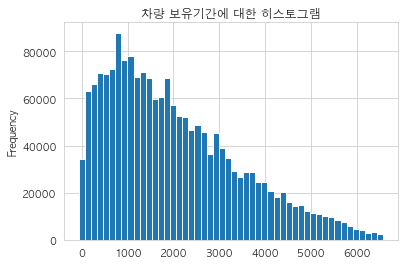

In [ ]:
# 현 시점 차량 소유 여부에 대한 변수 (보유 종료일 경우 N, 아직 보유 중인 경우 Y)
cars["CAR_HLDG_IS_CONTID"] = cars["CAR_HLDG_FNH_DT"].isna().map({True: "Y", False: "N"})

# 보유 기간 변수 정의 (보유종료일자 - 보유시작일자)
max_date = cars["WHOT_DT"].max()   # 출고일 중 가장 최근 날짜
cars["CAR_HLDG_FNH_DT"] = cars["CAR_HLDG_FNH_DT"].fillna(max_date + pd.to_timedelta(1, unit="D"))
cars["CAR_HLDG_DURATION"] = (cars["CAR_HLDG_FNH_DT"] - cars["WHOT_DT"]).dt.days
df_error = cars[cars.CAR_HLDG_DURATION < 0]   # 차량 보유 기간이 음수인 엔트리 제거

# 차량 보유 기간에 대한 히스토그램
cars.CAR_HLDG_DURATION.plot(kind="hist", bins=50)
plt.title("차량 보유기간에 대한 히스토그램")
plt.show()

In [ ]:
# 날짜 데이터에서의 가장 오래된 날짜
print(cars["WHOT_DT"].min())
print(cars["CAR_HLDG_FNH_DT"].min())

# 날짜 데이터에서의 가장 최근 날짜
print(cars["WHOT_DT"].max())
print(cars["CAR_HLDG_FNH_DT"].max())

2000-01-04 00:00:00
2000-05-29 00:00:00
2017-12-29 00:00:00
2017-12-30 00:00:00


- 해당 데이터의 시점은 2000.01부터 2017.12 까지로 판단됨.

### 모델 정보

#### 모델명

- 별도의 전처리 X

In [ ]:
# 차량명
cars.CAR_NM.unique()

array(['LF쏘나타', 'YF쏘나타', '그랜저HG', '아반떼MD', '그랜저IG', '싼타페 DM', '투싼ix',
       '엑센트', '제네시스 DH', '아이오닉', '아반떼AD', '투싼TL', '베라크루즈', 'EQ900',
       '벨로스터', '코나', 'VI 에쿠스', '맥스크루즈', 'i30 PD', 'i40', 'G80', 'G70',
       'i30', '아슬란', '아반떼', '클릭', '쏘나타', '테라칸', '그랜저', '싼타페', '베르나',
       '트라제', '제네시스', '투싼', '제네시스쿠페', '싼타모', 'i30 구형', '다이너스티',
       '다이너스티 택시', '갤로퍼', '라비타', 'i30 cw', '투스카니', '티뷰론', '아토스',
       '스타렉스 택시'], dtype=object)

#### 차량등급명 1

- 단순 오류를 수정.

In [ ]:
# 차량 등급 1
cars["CAR_CGRD_NM_1"].value_counts()

승용      1297952
RV       534765
해당없음       1797
Name: CAR_CGRD_NM_1, dtype: int64

In [ ]:
cars[cars["CAR_CGRD_NM_1"] == "해당없음"].CAR_NM.unique()

array(['쏘나타', '클릭', '베르나'], dtype=object)

- "해당없음"으로 분류된 엔트리들은 단순 기입 오류인 것 같으므로 해당 차량들의 등급에 맞게 "승용"으로 수정.

In [ ]:
# 오류 수정
for car in cars[cars["CAR_CGRD_NM_1"] == "해당없음"].CAR_NM.unique():
    temp_df = cars[cars["CAR_NM"] == car]
    idx = temp_df[temp_df["CAR_CGRD_NM_1"] == "해당없음"].index
    cars.loc[idx, "CAR_CGRD_NM_1"] = "승용"

#### 차량등급명 2


- 주어진 데이터에서는 차량의 **크기**를 기준으로 등급이 분류됨.

- 단순히 크기만으로는 차량별 특징을 충분히 반영할 수 없다고 판단.
    - ex) 제네시스 g70 = 쏘나타 = 중형

- **해당 모델의 브랜드 가치 및 특징**까지 고려해 좀 더 구체적으로  범주화.
    - 동일한 모델이더라도 시대에 따라 등급이 달라질 수 있음.
        - ex) 2000년대 초반의 그랜저는 현재 제네시스 시리즈와 등급
    - 해치백, 전기차 등의 특수 모델은 별도로 분리.

In [ ]:
cars.CAR_CGRD_NM_2.value_counts()

준중형       485826
중형        351765
대형        327239
중형SUV     281416
준중형SUV    153342
소형        116283
RV_미식별     80521
대형SUV      19486
스포츠        10988
승용_미식별      7648
Name: CAR_CGRD_NM_2, dtype: int64

In [ ]:
# 각 분류별 속한 차량 모델명
print("소형: {}".format(cars[cars.CAR_CGRD_NM_2 == "소형"].CAR_NM.unique()))
print("준중형: {}".format(cars[cars.CAR_CGRD_NM_2 == "준중형"].CAR_NM.unique()))
print("중형: {}".format(cars[cars.CAR_CGRD_NM_2 == "중형"].CAR_NM.unique()))
print("대형: {}".format(cars[cars.CAR_CGRD_NM_2 == "대형"].CAR_NM.unique()))
print("승용_미식별: {}".format(cars[cars.CAR_CGRD_NM_2 == "승용_미식별"].CAR_NM.unique()))
print()
print("중형SUV: {}".format(cars[cars.CAR_CGRD_NM_2 == "중형SUV"].CAR_NM.unique()))
print("준중형SUV: {}".format(cars[cars.CAR_CGRD_NM_2 == "준중형SUV"].CAR_NM.unique()))
print("대형SUV: {}".format(cars[cars.CAR_CGRD_NM_2 == "대형SUV"].CAR_NM.unique()))
print("RV_미식별: {}".format(cars[cars.CAR_CGRD_NM_2 == "RV_미식별"].CAR_NM.unique()))
print()
print("스포츠: {}".format(cars[cars.CAR_CGRD_NM_2 == "스포츠"].CAR_NM.unique()))

소형: ['엑센트' '벨로스터' '클릭' '베르나']
준중형: ['아반떼MD' '아이오닉' '아반떼AD' 'i30 PD' 'i30' '아반떼' 'i30 구형' 'i30 cw']
중형: ['LF쏘나타' 'YF쏘나타' 'i40' 'G70' '쏘나타']
대형: ['그랜저HG' '그랜저IG' '제네시스 DH' 'EQ900' 'VI 에쿠스' 'G80' '아슬란' '그랜저' '제네시스']
승용_미식별: ['다이너스티' '다이너스티 택시' '티뷰론' '아토스' '스타렉스 택시']

중형SUV: ['싼타페 DM' '맥스크루즈' '싼타페']
준중형SUV: ['투싼ix' '투싼TL' '코나' '투싼']
대형SUV: ['베라크루즈']
RV_미식별: ['테라칸' '트라제' '싼타모' '갤로퍼' '라비타']

스포츠: ['제네시스쿠페' '투스카니']


In [ ]:
# 택시 종류제거
rm_idx = cars[(cars.CAR_NM == "스타렉스 택시") | (cars.CAR_NM == "다이너스티 택시")].index
cars = cars.drop(rm_idx, axis=0)

In [ ]:
# 새롭게 범주화 진행
car_class_dict = {
    # 0. 소형 승용차
    '엑센트': "승용_소형",
    '클릭': "승용_소형",
    '베르나': "승용_소형",
    '아토스': "승용_소형",

    # 1. 준중형 승용차 (아반떼)
    '아반떼MD': "승용_준중형",
    '아반떼AD': "승용_준중형",
    '아반떼': "승용_준중형",

    # 2. 중형 승용차 (소나타)
    'LF쏘나타': "승용_중형",
    'YF쏘나타': "승용_중형",
    '쏘나타': "승용_중형",
    'i40': "승용_중형",

    # 3. 소형 ~ 준중형 RV
    '라비타': "RV_준중형이하",
    '코나': "RV_준중형이하",
    '투싼ix': "RV_준중형이하",
    '투싼TL': "RV_준중형이하",
    '투싼': "RV_준중형이하",

    # 4. 중형 ~ 대형 RV
    '트라제': "RV_중형이상",
    '싼타모': "RV_중형이상",
    '갤로퍼': "RV_중형이상",
    '테라칸': "RV_중형이상",
    '싼타페 DM': "RV_중형이상",
    '싼타페': "RV_중형이상",
    '베라크루즈': "RV_중형이상",
    '맥스크루즈': "RV_중형이상",

    # 5. 해치백
    'i30': "해치백",
    'i30 구형': "해치백",
    'i30 cw': "해치백",
    'i30 PD': "해치백",
    '벨로스터': "해치백",

    # 6. 준대형 승용차
    '그랜저HG': "승용_대형",
    '그랜저IG': "승용_대형",
    '아슬란': "승용_대형", 

    # 7. 고급(대형) 승용차
    '제네시스 DH': "승용_고급",
    '그랜저': "승용_고급", 
    '제네시스': "승용_고급",
    'VI 에쿠스': "승용_고급",
    'EQ900': "승용_고급",
    'G80': "승용_고급",
    'G70': "승용_고급",
    '다이너스티': "승용_고급",

    # 8. 전기차
    "아이오닉": "전기차",

    # 9. 스포츠카
    '투스카니': "스포츠카",
    '티뷰론': "스포츠카",
    '제네시스쿠페': "스포츠카",
}

# 차량 클래스 범주 추가
cars["CAR_CLASS"] = cars.CAR_NM.map(car_class_dict)
cars.shape

(1833444, 12)

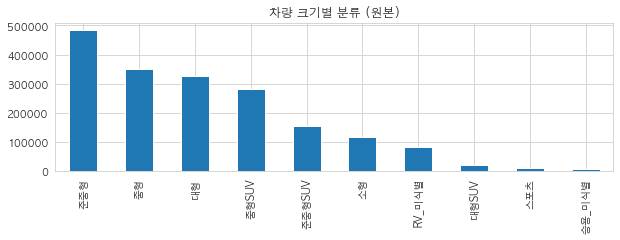

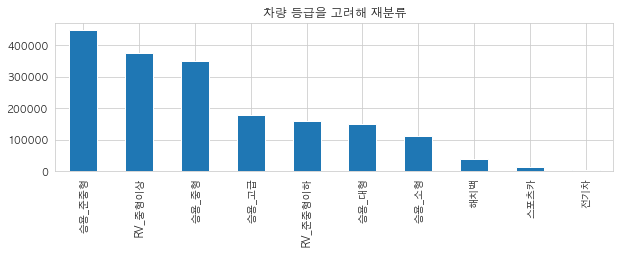

In [ ]:
# 차량 크기별 막대그래프
plt.figure(figsize=(10,6))
plt.subplot(2, 1, 2)
cars.CAR_CGRD_NM_2.value_counts().plot(kind="bar")
plt.title("차량 크기별 분류 (원본)")
plt.show()

# 차량 등급별 막대그래프
plt.figure(figsize=(10,6))
plt.subplot(2, 1, 1)
#cars.groupby("CAR_CLASS")["CUS_ID"].count().sort_index().plot(kind="bar")
cars.CAR_CLASS.value_counts().plot(kind="bar")
plt.title("차량 등급을 고려해 재분류")
plt.show()

### 엔진타입

엔진의 종류별로 범주화.

- 가솔린
- LPG
- 디젤
- 하이브리드
- 기타 (2007년 이전 데이터)

In [ ]:
GASOLINE = ['가솔린 2.0 CVVL', '가솔린 1.6', '가솔린 3.0', '가솔린 1.4', '가솔린 3.3', '가솔린 2.4', '3.3T', '1.6 가솔린', '1.6 터보', '가솔린 1.6 터보', '3.8', 
            '가솔린Y20', '가솔린 1.4 터보', '가솔린 2.0T', '가솔린', 'JS380', '가솔린 3.8','3.8 가솔린', '4.6', '가솔린 Q270', '2.0', '가솔린 2.0', '가솔린 N20',
            '1.4 가솔린', '가솔린 Q240', 'JS330', '가솔린 L330', '가솔린 2.0 T-GDi', '5.0', '가솔린F24', 'VS450', '가솔린 1.6 T-GDi', 'GDI 2.0', 'JL380', '가솔린 3.3T',
            '가솔린 S380', '가솔린 F24S', '가솔린 2.4 GDi', '가솔린 5.0', 'VL450', '2.7', '가솔린 F24']
LPG = ['LPG 2.0', 'LPi 2.0', 'LPG 3.0', 'LPI 1.6', 'LPG N20', 'LPG Q270', 'LPG 1.6', 'LPI']
DIESEL = ['디젤 2.0', '디젤', '디젤 1.6', '디젤 1.7', '3.0 디젤', '2.2', '디젤 2.2', '디젤 VGT', '디젤 1.5', '1.5 디젤', ]
HYBRID = ['하이브리드', '하이브리드2.0', '플러그인 하이브리드', '전기모터']
UNKNOWN = ['2007이전 데이터', '해당없음', '수소']   # 수소엔진은 해당하는 엔트리가 1개밖에 없기 때문에 2007년 이전 데이터와 함께 알수없음으로 분류함

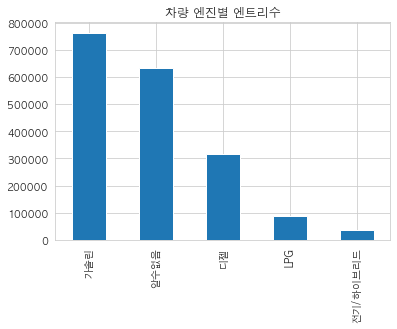

In [ ]:
def categorize_engine(engine_name):
    if engine_name in GASOLINE:
        return "가솔린"
    elif engine_name in LPG:
        return "LPG"
    elif engine_name in DIESEL:
        return "디젤"
    elif engine_name in HYBRID:
        return "전기/하이브리드"
    else:
        return "알수없음"

cars["CAR_ENG_CAT"] = cars.CAR_ENG_NM.apply(categorize_engine)   # 엔진 종류별로 범주화한 칼럼 추가
cars = cars.drop("CAR_ENG_NM", axis=1)  # 엔진명 삭제

# 막대그래프
cars["CAR_ENG_CAT"].value_counts().plot(kind="bar")
plt.title("차량 엔진별 엔트리수")
plt.show()

### 트림



트림명은 종류가 상당히 많고, 모델별로 사용되는 명칭이 상이하기 때문에 명백하게 구분할 수 있는 트림명만 사용해 범주화를 진행.

- "하": 중저가, 저가형 트림
- "중": 중급 트림
- "중상": 중상급 트림
- "상": 고가, 최고가형 트림
- "2007년 이전데이터": 2007년 이전 데이터
- "기타": 그 외 뚜렷한 구분이 어려운 트림명

In [ ]:
# 전체 트림명
cars["CAR_TRIM_NM"].unique()

array(['SMART', 'PREMIUM', 'MODERN', 'SMART SPECIAL', 'EXCLUSIVE',
       'Special', '.', 'Premium', 'PREMIUM SPECIAL', 'N', 'Modern',
       'Modern Special', 'EXCLUSIVE SP', 'PREMIUM COLLECTION', 'Style',
       'Smart', '장애우', 'STYLE', 'Q', 'EXCLUSIVE SPECIAL', 'VALUE PLUS',
       '밸류플러스', 'Premium Luxury', 'PYL', 'D-Spec', 'FLUX Premium S', '모던',
       'SPORT', 'Luxury', 'Smart Special', 'Supreme', 'MODERN SPECIAL',
       '2007이전 데이터', 'Premier', '럭셔리', 'S16', '로얄', 'LUXURY(구 PRIME-B)',
       'MODERN COLLECTION', '해당없음', 'Prestige', 'VXL', 'MX', 'SPECIAL',
       'Deluxe', 'MLX', 'VX', 'A', 'Elegance', 'B', '프라임', '노블',
       'Turbo-P', 'X', 'GRAND', 'GLS', 'X16 BLACK SPEICAL', 'Exclusive',
       'PREMIER', 'Modern TECH', 'LX20', '디럭스', 'Transform', 'Value',
       'Premier Black', 'MXL', 'TOP', 'X20', 'Elegance Special', 'E16',
       'GT-R', 'Royal', 'LMX20', 'DELUXE', '모범형', 'PRIME', '밀리언 팩', 'CLX',
       'Extreme', 'Turbo-R', 'Prime', 'HDE-Ⅲ', 'VIP', 'Grand', 'AVENUE',
 

In [ ]:
# 트림명 범주화
def categorize_trim(trim_name):

    # 하~중하위 트림
    if ("style" in trim_name.lower()) or ("스타일" in trim_name):               # 일반적인 승용차 모델의 하위 트림
        return "하"
    elif ("smart" in trim_name.lower()) or ("스마트" in trim_name):             # 일반적인 승용차 모델의 중하위 트림
        return "하"
    elif ("deluxe" in trim_name.lower()) or ("디럭스" in trim_name):            # 옛날 중대형 승용차 모델의 하위 트림
        return "하"
    elif trim_name == "밸류플러스":                                             # 아반떼AD
        return "하"
    elif trim_name == "CLX":                                                    # 중형 RV 모델의 하위 트림
        return "하"
    elif trim_name == "X20":                                                    # 준중형 RV 모델의 하위 트림
        return "하"
    elif trim_name == "JX":                                                     # 옛날 준중형 RV 모델의 하위 트림
        return "하"
    elif (trim_name == "I") or (trim_name == "I+"):                             # 전기차 모델의 하위 트림
        return "하"  
    elif (trim_name == "밸류플러스") or (trim_name == "I+"):                    # 아반떼AD와 아이오닉의 중하위 트림
        return "하" 
    elif (trim_name == "Younique") or (trim_name == "Unique"):                  # i30 시리즈의 중하위 트림
        return "하" 
    elif (trim_name == "GL"):                                                   # i30 구형 시리즈의 중하위 트림
        return "하"                


    # 중급 트림
    elif ("modern" in trim_name.lower()) or ("모던" in trim_name):              # 일반적인 승용차 모델의 중간 트림
        return "중"
    elif ("luxury" in trim_name.lower()) or ("럭셔리" in trim_name):            # 옛날 승용차 모델의 중간 트림
        return "중"
    elif ("s16" in trim_name.lower()):                                          # 준중형 승용차 모델의 중간 트림
        return "중"
    elif trim_name == "MLX":                                                    # 중형 RV 모델의 중간 트림
        return "중"
    elif trim_name == "MX":                                                     # 옛날 준중형 RV 모델의 중간 트림
        return "중"
    elif (trim_name == "N"):                                                    # 전기차 모델의 중간 트림
        return "중"
    elif (trim_name == "PYL") or ("d-spec" in trim_name.lower()):               # i30 시리즈의 중간 트림
        return "중"
    elif (trim_name == "GLS"):                                                  # i30 구형 시리즈의 중간 트림
        return "중"        


    # 중상급 트림
    elif ("premium" in trim_name.lower()) or ("프리미엄" in trim_name):         # 일반적인 승용차 모델의 중상급 트림
        return "중상"
    elif ("elegance" in trim_name.lower()) or ("강스" in trim_name):            # 옛날 중대형 승용차 모델의 중상급 트림
        return "중상"
    elif trim_name == "N+":                                                     # 전기차 모델의 중상급 트림
        return "중상"
    elif trim_name =="Extreme":                                                 # i30 시리즈의 중상급 트림
        return "중상"


    # 고급~최고급 트림
    elif ("exclusive" in trim_name.lower()) or ("익스클루시브" in trim_name):   # 일반적인 승용차 모델의 상급 트림
        return "상"
    elif ("prestige" in trim_name.lower()) or ("스티지" in trim_name):          # 일반적인 승용차 모델의 최상위 트림
        return "상"
    elif ("top" in trim_name.lower()):                                          # 옛날 중소형 자동차 모델의 상급 트림
        return "상"
    elif ("premier" in trim_name.lower()) or ("프리미어" in trim_name):         # 옛날 중대형 자동차 모델의 상급 트림
        return "상"
    elif ("million" in trim_name.lower()) or ("밀리언" in trim_name):           # 고급 차동차 스페셜 에디션
        return "상"
    elif ("x16" in trim_name.lower()):                                          # 준중형 승용차 모델의 상급 트림
        return "상"
    elif trim_name == "SLX":                                                    # 중형 RV 모델의 상급 트림
        return "상"
    elif trim_name == "LX20":                                                   # 준중형 RV 모델의 상급 트림
        return "상"
    elif trim_name == "LMX20":                                                  # 준중형 RV 모델의 상급 트림
        return "상"
    elif trim_name == "MXL":                                                    # 옛날 준중형 RV 모델의 상급 트림
        return "상"
    elif ("finest" in trim_name.lower()):                                       # 고급 승용차 모델의 최상급 트림
        return "상"
    elif (trim_name == "Q"):                                                    # 전기차 모델의 최상급 트림
        return "상"


    # 옛날 데이터
    elif trim_name == "2007이전 데이터":
        return "2007이전 데이터"

    # 그 외
    else:
        return "기타"


# 차량 트림명 범주화
cars["CAR_TRIM_CAT"] = cars.CAR_TRIM_NM.astype(str).apply(categorize_trim)
cars = cars.drop("CAR_TRIM_NM", axis=1) # 차량 트림명 삭제

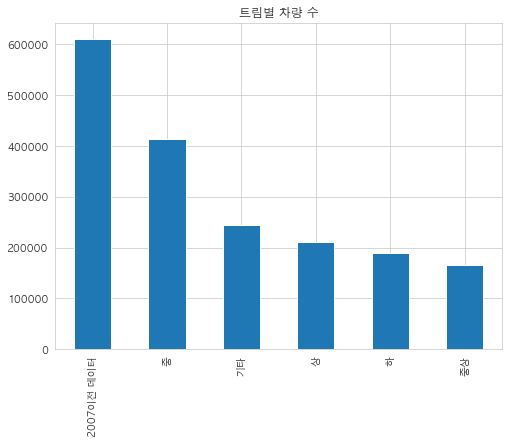

In [ ]:
# 트림 등급별 비율 시각화
plt.figure(figsize=(8,6))
cars.CAR_TRIM_CAT.value_counts().plot(kind="bar")
plt.title("트림별 차량 수")
plt.show()

In [ ]:
# 전처리된 차량정보 데이터
print(cars.shape)
cars.head()

(1833444, 12)


,CAR_ID,CUS_ID,WHOT_DT,CAR_HLDG_FNH_DT,CAR_NM,CAR_CGRD_NM_1,CAR_CGRD_NM_2,CAR_HLDG_IS_CONTID,CAR_HLDG_DURATION,CAR_CLASS,CAR_ENG_CAT,CAR_TRIM_CAT
0,H1308052741CBFA022907,AOZZZZO010000035,2014-06-27,2017-08-31,LF쏘나타,승용,중형,N,1161,승용_중형,가솔린,하
1,H1308050341LBEA656859,AOZZZZO010000067,2014-07-11,2017-12-30,YF쏘나타,승용,중형,Y,1268,승용_중형,LPG,중상
2,H1308052741DBFA038433,AOZZZZO010000190,2014-07-07,2017-12-30,LF쏘나타,승용,중형,Y,1272,승용_중형,LPG,중상
3,H13080607413BFA007670,AOZZZZO010000371,2014-07-11,2017-12-30,그랜저HG,승용,대형,Y,1268,승용_대형,전기/하이브리드,중상
4,H1308052741DBFA091812,AOZZZZO010000492,2015-01-20,2017-12-30,LF쏘나타,승용,중형,Y,1075,승용_중형,LPG,중상


## 접촉이력정보

In [ ]:
# 접촉일자 칼럼 날짜 자료형으로 변환
contacts["CNTC_DT"] = pd.to_datetime(contacts.CNTC_DT.astype(str))

### 접촉채널

접촉 채널을 크게 대면/비대면으로 범주화.

- 당첨/참석/응모/이벤트/캠페인은 빈도수가 낮고 분류가 애매하므로 제외.

방문(대면)    0.7872
전화        0.1366
인터넷       0.0756
당첨        0.0002
참석        0.0002
응모        0.0001
이벤트       0.0000
캠페인       0.0000
Name: CNTC_CHAN_NM, dtype: float64


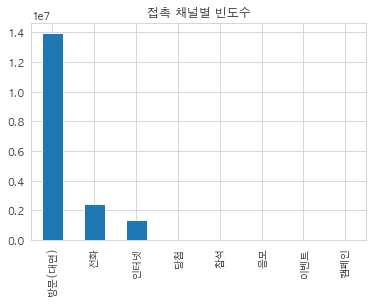

In [ ]:
# 접촉채널별 빈도수
print(np.round(contacts["CNTC_CHAN_NM"].value_counts() / len(contacts), 4))
contacts["CNTC_CHAN_NM"].value_counts().plot(kind="bar", title="접촉 채널별 빈도수")
plt.show()

In [ ]:
# 접촉 채널 범주화
channel_cat = {
    "방문(대면)": "대면",
    '전화': "비대면", '인터넷': "비대면",
    "당첨": None, "응모": None, "참석": None, "캠페인": None, "이벤트": None
}

# 새로운 칼럼 정의
contacts["CNTC_CHAN_CAT"] = contacts.CNTC_CHAN_NM.map(channel_cat)
contacts = contacts.drop("CNTC_CHAN_NM", axis=1)  # 기존 접촉 채널 변수 삭제

### 접촉업무

- 접촉 업무의 성격에 따라 다음의 4가지 범주로 분류
    - 정비
    - 상담
    - 견적
    - 서비스

In [ ]:
# 접촉업무별 비율
np.round(contacts["CNTC_AFFR_SCN_NM"].value_counts() / len(contacts), 3)

정비            0.779
일반상담          0.131
견적            0.070
이벤트           0.006
불만상담          0.006
시승센터시승        0.006
비포서비스         0.002
비포서비스&무상점검    0.001
고객초청행사        0.000
영업활동(TM)      0.000
영업활동(대면)      0.000
Name: CNTC_AFFR_SCN_NM, dtype: float64

In [ ]:
# 접촉 업무 범주화

purpose_cat = {
    "정비": "정비",
    '일반상담': "상담", "불만상담": "상담", 
    '견적': "견적", "시승센터시승": "견적", "영업활동(TM)": "견적", "영업활동(대면)": "견적",
    "이벤트": "서비스", "비포서비스": "서비스", "비포서비스&무상점검": "서비스", "고객초청행사": "서비스"
}

# 새로운 칼럼 정의
contacts["CNTC_AFFR_SCN_CAT"] = contacts.CNTC_AFFR_SCN_NM.map(purpose_cat)
contacts = contacts.drop("CNTC_AFFR_SCN_NM", axis=1)  # 기존 접촉 업무 변수 삭제

In [ ]:
# 전처리된 접촉이력 데이터
print(contacts.shape)
contacts.head()

(17734097, 5)


,CNTC_SN,CUS_ID,CNTC_DT,CNTC_CHAN_CAT,CNTC_AFFR_SCN_CAT
0,172591627,AOZZZZO010000035,2015-05-04,대면,정비
1,172610507,AOZZZZO010000035,2015-05-04,대면,정비
2,306638131,AOZZZZO010000035,2016-12-02,대면,정비
3,306641393,AOZZZZO010000035,2016-12-02,대면,정비
4,344010325,AOZZZZO010000035,2017-02-15,대면,정비


## 데이터 통합 및 추가적인 특성 정의

### 데이터 통합

- 고객 정보 데이터와 차량 구매 정보 데이터를 고객 ID (CUS_ID) 칼럼을 기준으로 통합.

In [ ]:
df_merged = pd.merge(customers, cars, on="CUS_ID", how="left")   # 고객 + 차량 정보 데이터
print(df_merged.shape)

(1833986, 21)


In [ ]:
# 구매내역이 없는 엔트리
print("구매내역이 없는 엔트리 수: {}".format(df_merged.CAR_ID.isnull().sum()))

# 해당 엔트리들 삭제
df_merged = df_merged.drop(df_merged[df_merged.CAR_ID.isnull()].index, axis=0).reset_index(drop=True)
print(df_merged.shape)

구매내역이 없는 엔트리 수: 586
(1833400, 21)


In [ ]:
# 고객정보와 차량정보가 통합된 데이터
df_merged.head()

,CUS_ID,PSN_BIZR_YN,SEX_SCN_NM,CUS_ADM_TRY_NM,CUS_N_ADMZ_NM,CUS_ADMB_NM,CLB_HOUS_PYG_NM,REAI_BZTC_AVG_PCE,B_YEAR,PCE_PER_PYG,...,WHOT_DT,CAR_HLDG_FNH_DT,CAR_NM,CAR_CGRD_NM_1,CAR_CGRD_NM_2,CAR_HLDG_IS_CONTID,CAR_HLDG_DURATION,CAR_CLASS,CAR_ENG_CAT,CAR_TRIM_CAT
0,AOZZZZO010000035,N,남자,전라남도,영암군,시종면,NaN,NaN,1930,NaN,...,2014-06-27,2017-08-31,LF쏘나타,승용,중형,N,1161.0,승용_중형,가솔린,하
1,AOZZZZO010000067,N,남자,경상남도,진주시,NaN,NaN,NaN,1933,NaN,...,2014-07-11,2017-12-30,YF쏘나타,승용,중형,Y,1268.0,승용_중형,LPG,중상
2,AOZZZZO010000190,N,남자,NaN,NaN,NaN,23.0,13400.0,1937,582.608696,...,2014-07-07,2017-12-30,LF쏘나타,승용,중형,Y,1272.0,승용_중형,LPG,중상
3,AOZZZZO010000371,N,남자,서울특별시,마포구,NaN,NaN,NaN,1940,NaN,...,2014-07-11,2017-12-30,그랜저HG,승용,대형,Y,1268.0,승용_대형,전기/하이브리드,중상
4,AOZZZZO010000492,N,남자,광주광역시,북구,NaN,NaN,NaN,1941,NaN,...,2015-01-20,2017-12-30,LF쏘나타,승용,중형,Y,1075.0,승용_중형,LPG,중상


### 차량 구매횟수 추가

- 2000.01 ~ 2017.12 동안 고객별 전체 차량 구매횟수에 대한 칼럼을 추가. (TOTAL_NUM_PURCHASES)

In [ ]:
# 고객의 ID와 전체 구매횟수에 대한 정보가 담긴 딕셔너리
customer_dict = dict(df_merged.groupby("CUS_ID").count()["SEX_SCN_NM"])

# 고객별 전체 구매횟수 칼럼 추가
df_merged["TOTAL_NUM_PURCHASES"] = df_merged.CUS_ID.apply(lambda x: customer_dict[x])

df_merged.head()

,CUS_ID,PSN_BIZR_YN,SEX_SCN_NM,CUS_ADM_TRY_NM,CUS_N_ADMZ_NM,CUS_ADMB_NM,CLB_HOUS_PYG_NM,REAI_BZTC_AVG_PCE,B_YEAR,PCE_PER_PYG,...,CAR_HLDG_FNH_DT,CAR_NM,CAR_CGRD_NM_1,CAR_CGRD_NM_2,CAR_HLDG_IS_CONTID,CAR_HLDG_DURATION,CAR_CLASS,CAR_ENG_CAT,CAR_TRIM_CAT,TOTAL_NUM_PURCHASES
0,AOZZZZO010000035,N,남자,전라남도,영암군,시종면,NaN,NaN,1930,NaN,...,2017-08-31,LF쏘나타,승용,중형,N,1161.0,승용_중형,가솔린,하,1
1,AOZZZZO010000067,N,남자,경상남도,진주시,NaN,NaN,NaN,1933,NaN,...,2017-12-30,YF쏘나타,승용,중형,Y,1268.0,승용_중형,LPG,중상,1
2,AOZZZZO010000190,N,남자,NaN,NaN,NaN,23.0,13400.0,1937,582.608696,...,2017-12-30,LF쏘나타,승용,중형,Y,1272.0,승용_중형,LPG,중상,1
3,AOZZZZO010000371,N,남자,서울특별시,마포구,NaN,NaN,NaN,1940,NaN,...,2017-12-30,그랜저HG,승용,대형,Y,1268.0,승용_대형,전기/하이브리드,중상,1
4,AOZZZZO010000492,N,남자,광주광역시,북구,NaN,NaN,NaN,1941,NaN,...,2017-12-30,LF쏘나타,승용,중형,Y,1075.0,승용_중형,LPG,중상,1


### 고객 나이 추가

- 차량의 출고일을 기준으로 **차량을 구매했을 당시 고객의 나이**에 대한 칼럼을 추가 (CUS_AGE)
- 나이를 연령대별로 범주화 한 칼럼을 추가적으로 정의 (CUS_AGE_CAT)

In [ ]:
# 고객 나이 변수 추가 (출고일 기준)
df_merged["CUS_AGE"] = df_merged["WHOT_DT"].dt.year - df_merged["B_YEAR"]

# 20세 이하가 차를 소유하는 것은 일반적이지 않으므로 제외
under_20 = df_merged[df_merged["CUS_AGE"] < 20 ].CUS_ID.index
df_merged.drop(under_20, axis=0, inplace=True)

# 연령대 별로 범주화
bin_interval = [19, 29, 39, 49, 59, 69, df_merged.CUS_AGE.max()]
bin_labels = ["20대", "30대", "40대", "50대", "60대", "70이상"]
df_merged['CUS_AGE_CAT'] = pd.cut(df_merged['CUS_AGE'], bins = bin_interval, labels=bin_labels)

df_merged.head()

,CUS_ID,PSN_BIZR_YN,SEX_SCN_NM,CUS_ADM_TRY_NM,CUS_N_ADMZ_NM,CUS_ADMB_NM,CLB_HOUS_PYG_NM,REAI_BZTC_AVG_PCE,B_YEAR,PCE_PER_PYG,...,CAR_CGRD_NM_1,CAR_CGRD_NM_2,CAR_HLDG_IS_CONTID,CAR_HLDG_DURATION,CAR_CLASS,CAR_ENG_CAT,CAR_TRIM_CAT,TOTAL_NUM_PURCHASES,CUS_AGE,CUS_AGE_CAT
0,AOZZZZO010000035,N,남자,전라남도,영암군,시종면,NaN,NaN,1930,NaN,...,승용,중형,N,1161.0,승용_중형,가솔린,하,1,84,70이상
1,AOZZZZO010000067,N,남자,경상남도,진주시,NaN,NaN,NaN,1933,NaN,...,승용,중형,Y,1268.0,승용_중형,LPG,중상,1,81,70이상
2,AOZZZZO010000190,N,남자,NaN,NaN,NaN,23.0,13400.0,1937,582.608696,...,승용,중형,Y,1272.0,승용_중형,LPG,중상,1,77,70이상
3,AOZZZZO010000371,N,남자,서울특별시,마포구,NaN,NaN,NaN,1940,NaN,...,승용,대형,Y,1268.0,승용_대형,전기/하이브리드,중상,1,74,70이상
4,AOZZZZO010000492,N,남자,광주광역시,북구,NaN,NaN,NaN,1941,NaN,...,승용,중형,Y,1075.0,승용_중형,LPG,중상,1,74,70이상


## 전처리된 데이터 저장

In [ ]:
# 고객별 차량 구매내역 데이터
df_merged.to_csv("./data/차량구매내역_전처리.csv", index=False)

# 접촉이력 데이터
contacts.to_csv("./data/접촉이력_전처리.csv", index=False)

## 평당 주택 가격에 대한 회귀

- 앞서 평당 주택 가격의 약 45% 정도가 결측치임을 확인함.
- 회귀 모델을 훈련시켜 해당 결측치들을 보완.

<br>

사용할 독립변수:

- 고객의 거주 시군구명
- 고객의 나이

<br>

- "평당 주택 가격"은 해당 데이터에서 가용할 수 있는 변수 중 고객의 **"거주지역"** 및 **"나이"**에 가장 크게 영향을 받을 것이라고 판단. 

- 시군구명의 종류가 200개가 넘어가므로 이를 원핫 인코딩 하는 과정에서 sparse feature의 개수가 급격하게 늘어나기 때문에 높은 feature 개수에 적합한 심층 신경망 모형을 사용.


In [ ]:
# 저장된 데이터 불러오기
df_merged = pd.read_csv("./data/차량구매내역_전처리.csv")

In [ ]:
# 회귀모델의 독립변수 정의
cols_reg = ["CUS_N_ADMZ_NM", "CUS_AGE", "PCE_PER_PYG"]

# 회귀용 데이터셋 정의
df_reg = df_merged[cols_reg]
df_reg = df_reg[~df_reg.PCE_PER_PYG.isna()]
df_reg = df_reg[~df_reg.CUS_N_ADMZ_NM.isna()].reset_index(drop=True)

X = df_reg[["CUS_N_ADMZ_NM", "CUS_AGE"]]
y = df_reg["PCE_PER_PYG"]

print(X.shape)
print(y.shape)

(875108, 2)
(875108,)


In [ ]:
# 모델링을 위한 데이터 전처리 파이프라인 정의

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

num_attribs = ["CUS_AGE"]
cat_attribs = ["CUS_N_ADMZ_NM"]

full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),   # 수치형 자료(나이) 표준화
        ("cat", OneHotEncoder(), cat_attribs),    # 범주형 자료(시군구명) 원핫인코딩
    ])

X_prepro = full_pipeline.fit_transform(X).toarray()
print(X_prepro.shape)

(875108, 228)


In [ ]:
# train/test 데이터 분리

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prepro, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(700086, 228)
(700086,)
(175022, 228)
(175022,)


In [ ]:
# Regression DNN 구조 정의
model = keras.models.Sequential([
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal", input_shape=(X_train.shape[1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(1)
])

In [ ]:
# 학습 파라미터 설정
NUM_EPOCHS = 10
BATCH_SIZE = 32
VALID_SPLIT = 0.2

In [ ]:
# 학습률 스케쥴러 (기간별 고정 스케쥴링 사용)
def piecewise_constant_fn(epoch):
    if epoch <= 3:
        return 0.01
    elif epoch <= 6:
        return 0.005
    else:
        return 0.001
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)


# EarlyStopping 콜백 정의
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=5)

In [ ]:
# 모델 컴파일링 및 학습 진행
model.compile(loss="mean_squared_error", optimizer="nadam")
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALID_SPLIT, 
                    callbacks=[early_stopping_cb, lr_scheduler])

Epoch 1/10
17503/17503 [==============================] - 28s 2ms/step - loss: 751467.3860 - val_loss: 497140.5625
Epoch 2/10
17503/17503 [==============================] - 25s 1ms/step - loss: 554045.6896 - val_loss: 493503.9688
Epoch 3/10
17503/17503 [==============================] - 26s 1ms/step - loss: 548491.0274 - val_loss: 497273.6250
Epoch 4/10
17503/17503 [==============================] - 26s 1ms/step - loss: 550478.9687 - val_loss: 490716.9688
Epoch 5/10
17503/17503 [==============================] - 26s 1ms/step - loss: 542301.8323 - val_loss: 495065.6875
Epoch 6/10
17503/17503 [==============================] - 27s 2ms/step - loss: 539109.1071 - val_loss: 495611.0312
Epoch 7/10
17503/17503 [==============================] - 26s 1ms/step - loss: 545141.6932 - val_loss: 496097.0312
Epoch 8/10
17503/17503 [==============================] - 26s 1ms/step - loss: 535984.9464 - val_loss: 496537.9375
Epoch 9/10
17503/17503 [==============================] - 27s 2ms/step - loss: 5

In [ ]:
# 테스트셋에 대해 성능 평가
model.evaluate(X_test, y_test)

5470/5470 [==============================] - 3s 542us/step - loss: 492611.2188


492611.21875

In [ ]:
# 평당 주택 가격을 예측할 데이터셋 정의
df_pred = df_merged[["CUS_N_ADMZ_NM", "CUS_AGE", "PCE_PER_PYG", "CAR_ID"]]
df_pred = df_pred[df_pred.PCE_PER_PYG.isna()]
df_pred = df_pred[~df_pred.CUS_N_ADMZ_NM.isna()]

# 독립변수 및 종속변수
X = df_pred[["CUS_N_ADMZ_NM", "CUS_AGE"]]
y_index = df_pred.index

# 독립변수 전처리
X_prepro = full_pipeline.transform(X).toarray()

# 훈련된 모델을 바탕으로 종속변수 예측
y_pred = model.predict(X_prepro).reshape(-1).astype(float)

# 차량ID와 예측값을 매핑한 딕셔너리 형태로 기록
predictions = dict(zip(df_pred.CAR_ID, y_pred))

In [ ]:
# 예측값 저장
import json
save_path = "./data/PCE_PER_PYG_predictions.json"
json.dump(predictions, open(save_path, 'w'))

- 해당 예측값들은 추후 Task 2의 모델링에서 사용될 예정.